In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from xgboost import XGBRegressor

In [3]:
sales_data = pd.read_csv('train.csv')
sales_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [5]:
sales_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

filling the null values in Item_weight column with mean values

In [6]:
sales_data['Item_Weight'].fillna(sales_data['Item_Weight'].mean(), inplace=True)
sales_data['Item_Weight'].isnull().sum()

0

__Replacing the missing values in Outlet_Size with mode. But the idea of replacing such value with mode is a bit tricky here.__   
  
The Outlet_Size indirectly depends on the Outlet_type. Hence, you cannot take the mode of the whole data and replace the missing values. In this case, you have to determine the mode of each Outlet_Size for each particular Outlet_type. The following code does that exactly.

In [7]:
mode_of_outlet_size = sales_data.pivot_table(values='Outlet_Size', columns=['Outlet_Type'], aggfunc=(lambda x: x.mode()[0]))

In [8]:
mode_of_outlet_size

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


The above table shows the mode of _Outlet_Size_ for the respective _Outlet_Type_

In [9]:
missing_values = sales_data['Outlet_Size'].isnull() ## extracting the missing values as boolean array
missing_values

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool

In [10]:
sales_data.loc[missing_values, 'Outlet_Size'] = sales_data.loc[missing_values, 'Outlet_Type'].apply(lambda x: mode_of_outlet_size[x])

In [11]:
sales_data.loc[missing_values, 'Outlet_Size']

3       Small
8       Small
9       Small
25      Small
28      Small
        ...  
8502    Small
8508    Small
8509    Small
8514    Small
8519    Small
Name: Outlet_Size, Length: 2410, dtype: object

In [12]:
sales_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [13]:
sales_data['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [14]:
sales_data.replace({'Item_Fat_Content': {'LF':'Low Fat', 'low fat': 'Low Fat', 'reg':'Regular'}}, inplace=True)
sales_data['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [15]:
sales_data['Item_Identifier'] = sales_data['Item_Identifier'].apply(lambda x: x[:2])
sales_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FD,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DR,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FD,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FD,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NC,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


__DATA ANALYSIS USING PLOTS__

lets see the type of items in the dataset like dairy, vegetables, etc.

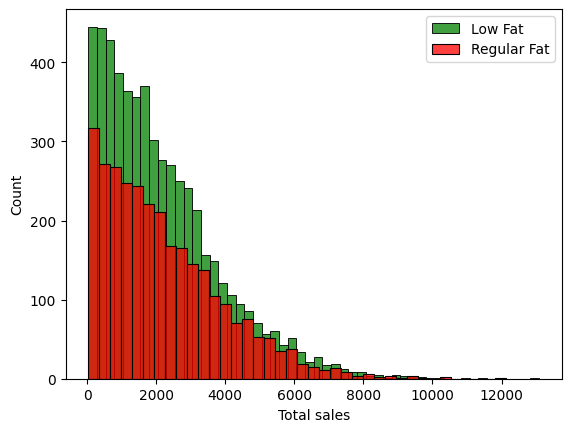

In [16]:
fig = plt.figure()
sns.histplot(sales_data[sales_data['Item_Fat_Content']=='Low Fat']['Item_Outlet_Sales'], color='green', label='Low Fat')
sns.histplot(sales_data[sales_data['Item_Fat_Content']=='Regular']['Item_Outlet_Sales'], color='red', label='Regular Fat')
plt.xlabel('Total sales')
plt.legend()
plt.show()
fig.clear()

### The plot looks fine, but it is important to note the data set classifies even non-consumable items as _Low Fat_. That is why the above plot is biased. So, before plotting the sales with the respect to fat content, let us first separate the dataset into consumables (that can be eaten) and non-consumables

In [17]:
sales_data['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [18]:
consumables = sales_data[(sales_data['Item_Identifier'].str.startswith('FD')) | (sales_data['Item_Identifier'].str.startswith('DR'))]
non_consumables = sales_data[(sales_data['Item_Identifier'].str.startswith('NC'))]
non_consumables

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
4,NC,8.930000,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
16,NC,11.800000,Low Fat,0.008596,Health and Hygiene,115.3492,OUT018,2009,Medium,Tier 3,Supermarket Type2,1621.8888
22,NC,14.600000,Low Fat,0.025698,Household,196.5084,OUT035,2004,Small,Tier 2,Supermarket Type1,1587.2672
25,NC,13.000000,Low Fat,0.099887,Household,45.9060,OUT017,2007,Small,Tier 2,Supermarket Type1,838.9080
31,NC,18.600000,Low Fat,0.080829,Health and Hygiene,96.4436,OUT018,2009,Medium,Tier 3,Supermarket Type2,2741.7644
...,...,...,...,...,...,...,...,...,...,...,...,...
8500,NC,20.350000,Low Fat,0.000000,Household,125.1678,OUT017,2007,Small,Tier 2,Supermarket Type1,1907.5170
8502,NC,8.420000,Low Fat,0.070712,Household,216.4192,OUT045,2002,Small,Tier 2,Supermarket Type1,3020.0688
8504,NC,12.857645,Low Fat,0.124111,Household,111.7544,OUT027,1985,Medium,Tier 3,Supermarket Type3,4138.6128
8516,NC,18.600000,Low Fat,0.118661,Others,58.7588,OUT018,2009,Medium,Tier 3,Supermarket Type2,858.8820


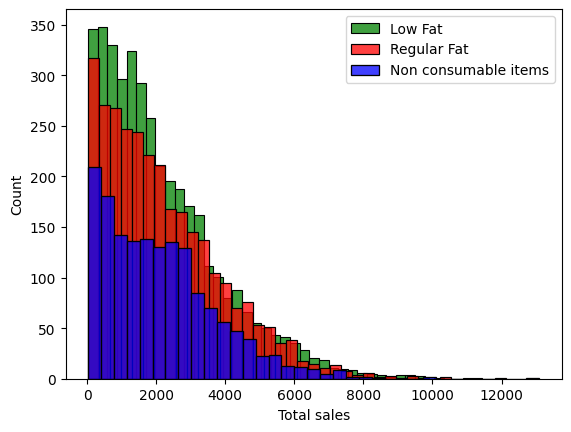

In [19]:
fig = plt.figure()
sns.histplot(consumables[consumables['Item_Fat_Content']=='Low Fat']['Item_Outlet_Sales'], color='green', label='Low Fat')
sns.histplot(consumables[consumables['Item_Fat_Content']=='Regular']['Item_Outlet_Sales'], color='red', label='Regular Fat')
sns.histplot(non_consumables['Item_Outlet_Sales'], color='blue', label='Non consumable items')
plt.xlabel('Total sales')
plt.legend()
plt.show()
fig.clear()

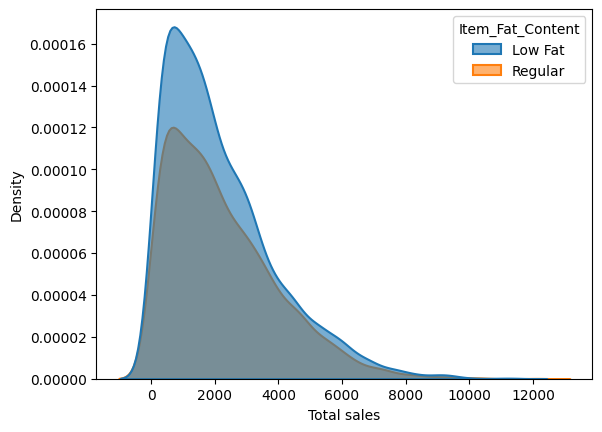

In [20]:
fig = plt.figure()
sns.kdeplot(data=consumables, x="Item_Outlet_Sales", hue="Item_Fat_Content", fill=True, alpha=0.6, linewidth=1.5)
plt.xlabel('Total sales')
# plt.legend()
plt.show()
fig.clear()


### This is much better. We can see that the low fat items perform slightly better at sales compared to regular fat items. Not suprising as everyone is trying to be healthy now a days and hence try to buy low fat.

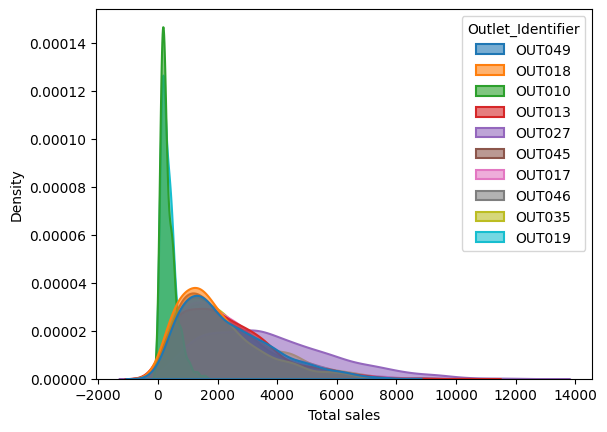

In [89]:
fig = plt.figure()
sns.kdeplot(data=consumables, x="Item_Outlet_Sales", hue="Outlet_Identifier", fill=True, alpha=0.6, linewidth=1.5)
plt.xlabel('Total sales')
# plt.legend()
plt.show()
fig.clear()

## _Correlation between the different columns and sales_

In [23]:
sales_data.corr(numeric_only=True)['Item_Outlet_Sales'].reset_index()

,index,Item_Outlet_Sales
0,Item_Weight,0.011550
1,Item_Visibility,-0.128625
2,Item_MRP,0.567574
3,Outlet_Establishment_Year,-0.049135
4,Item_Outlet_Sales,1.000000


In [ ]:
f = plt.figure(figsize=(19, 15))
# plt.imshow()
plt.matshow(sales_data.corr(), fignum=f.number, cmap='Blues')
plt.xticks(range(sales_data.select_dtypes(['number']).shape[1]), sales_data.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(sales_data.select_dtypes(['number']).shape[1]), sales_data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [20]:
sales_data['Outlet_Identifier'].value_counts()

OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

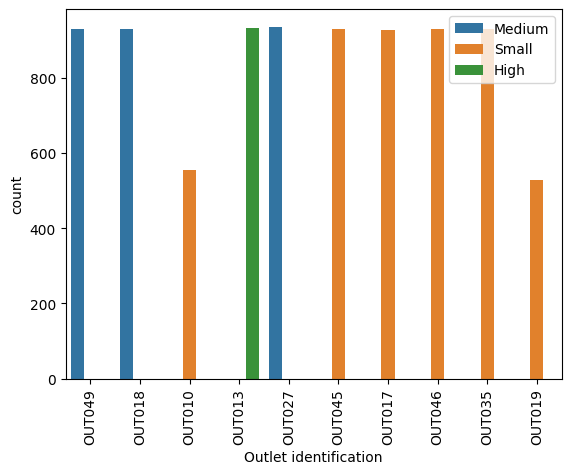

In [87]:
fig = plt.figure()
sns.countplot(data=sales_data, x="Outlet_Identifier", hue='Outlet_Size')
plt.xlabel('Outlet identification')
plt.legend()
plt.xticks(rotation=90)
plt.show()
fig.clear()

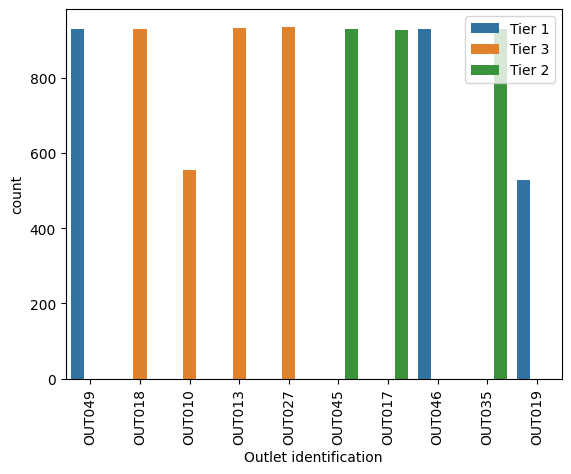

In [88]:
fig = plt.figure()
sns.countplot(data=sales_data, x="Outlet_Identifier", hue='Outlet_Location_Type')
plt.xlabel('Outlet identification')
plt.legend()
plt.xticks(rotation=90)
plt.show()
fig.clear()

In [23]:
sales_data['Outlet_Size'].value_counts()

Small     4798
Medium    2793
High       932
Name: Outlet_Size, dtype: int64

In [34]:
sales_mean_by_size = sales_data.groupby('Outlet_Size')['Item_Outlet_Sales'].mean().reset_index()

# Optional: Rename columns for better readability
sales_mean_by_size.columns = ['Supermarket Size', 'Average Total Sales']
sales_mean_by_size

,Supermarket Size,Average Total Sales
0,High,2298.995256
1,Medium,2681.603542
2,Small,1867.182814


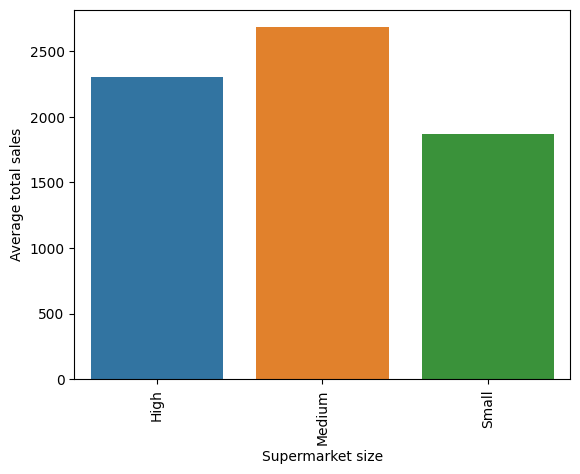

In [30]:
fig = plt.figure()
sns.barplot(x="Supermarket Size", y='Average Total Sales',data=sales_mean_by_size)
plt.xlabel('Supermarket size')
plt.ylabel('Average total sales')
# plt.legend()
plt.xticks(rotation=90)
plt.show()
fig.clear()

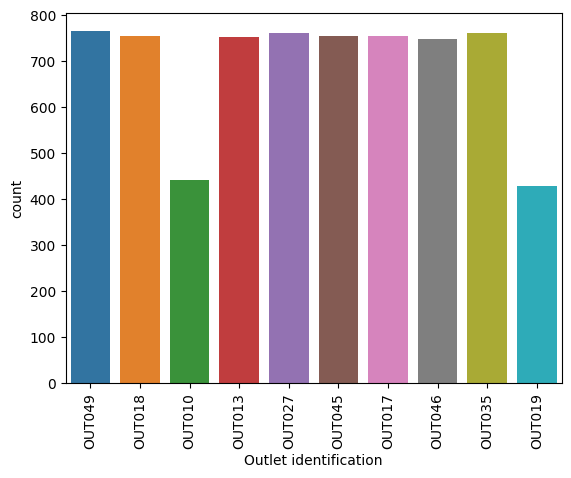

In [36]:
fig = plt.figure()
sns.countplot(data=consumables, x="Outlet_Identifier")
plt.xlabel('Outlet identification')
# plt.legend()
plt.xticks(rotation=90)
plt.show()
fig.clear()

In [28]:
sales_mean_by_outlet = sales_data.groupby('Outlet_Identifier')['Item_Outlet_Sales'].mean().reset_index()

# Optional: Rename columns for better readability
sales_mean_by_outlet.columns = ['Outlet ID', 'Average Sales']
sales_mean_by_outlet = sales_mean_by_outlet.sort_values(by='Average Sales', ascending = False)
sales_mean_by_outlet

,Outlet ID,Average Sales
5,OUT027,3694.038558
6,OUT035,2438.841866
9,OUT049,2348.354635
2,OUT017,2340.675263
1,OUT013,2298.995256
8,OUT046,2277.844267
7,OUT045,2192.384798
3,OUT018,1995.498739
4,OUT019,340.329723
0,OUT010,339.351662


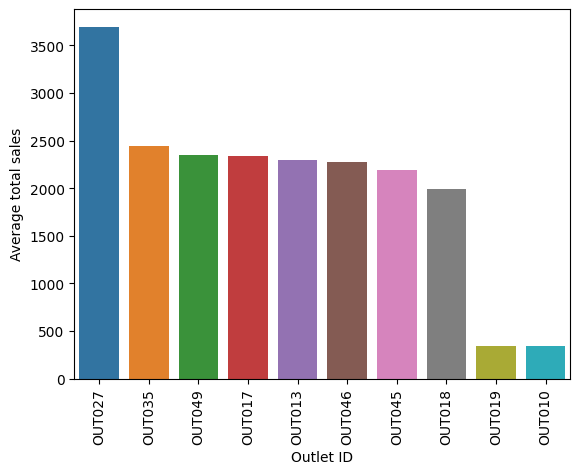

In [35]:
fig = plt.figure()
sns.barplot(x="Outlet ID", y='Average Sales',data=sales_mean_by_outlet)
plt.xlabel('Outlet ID')
plt.ylabel('Average total sales')
# plt.legend()
plt.xticks(rotation=90)
plt.show()
fig.clear()

In [68]:
sales_data.groupby(['Outlet_Identifier', 'Outlet_Size']).size()

Outlet_Identifier  Outlet_Size
OUT010             Small          555
OUT013             High           932
OUT017             Small          926
OUT018             Medium         928
OUT019             Small          528
OUT027             Medium         935
OUT035             Small          930
OUT045             Small          929
OUT046             Small          930
OUT049             Medium         930
dtype: int64

In [81]:
sales_mean_by_outlet_and_size = sales_data.groupby(['Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type'])['Item_Outlet_Sales'].mean().reset_index()

# Optional: Rename columns for better readability
sales_mean_by_outlet_and_size.columns = ['Outlet ID', 'Outlet Size','Outlet Location','Average Sales']
sales_mean_by_outlet_and_size = sales_mean_by_outlet_and_size.sort_values(by='Average Sales', ascending = False)
sales_mean_by_outlet_and_size

,Outlet ID,Outlet Size,Outlet Location,Average Sales
5,OUT027,Medium,Tier 3,3694.038558
6,OUT035,Small,Tier 2,2438.841866
9,OUT049,Medium,Tier 1,2348.354635
2,OUT017,Small,Tier 2,2340.675263
1,OUT013,High,Tier 3,2298.995256
8,OUT046,Small,Tier 1,2277.844267
7,OUT045,Small,Tier 2,2192.384798
3,OUT018,Medium,Tier 3,1995.498739
4,OUT019,Small,Tier 1,340.329723
0,OUT010,Small,Tier 3,339.351662


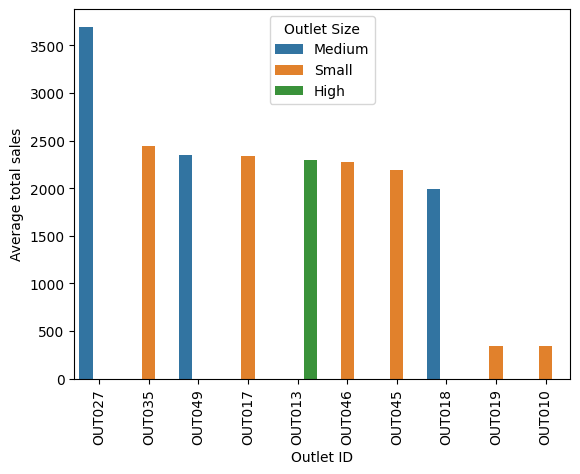

In [82]:
fig = plt.figure()
sns.barplot(x="Outlet ID", y='Average Sales',data=sales_mean_by_outlet_and_size, hue='Outlet Size')
plt.xlabel('Outlet ID')
plt.ylabel('Average total sales')
# plt.legend()
plt.xticks(rotation=90)
plt.show()
fig.clear()

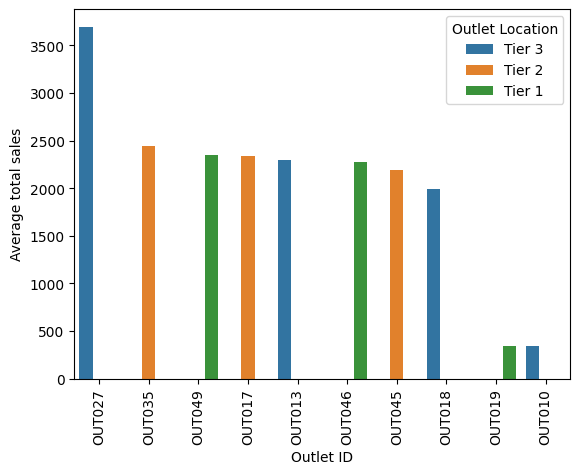

In [83]:
fig = plt.figure()
sns.barplot(x="Outlet ID", y='Average Sales',data=sales_mean_by_outlet_and_size, hue='Outlet Location')
plt.xlabel('Outlet ID')
plt.ylabel('Average total sales')
# plt.legend()
plt.xticks(rotation=90)
plt.show()
fig.clear()

## __DATA PREPROCESSING AND MODEL BUILDING__

In [47]:
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
encoder = LabelEncoder()
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [50]:
classified_columns = ['Item_Identifier', 'Item_Fat_Content', 'Item_Type','Outlet_Identifier','Outlet_Size','Outlet_Location_Type','Outlet_Type']
for columns in classified_columns:
    sales_data[columns] = encoder.fit_transform(sales_data[columns])

In [51]:
sales_data.head()
print(sales_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   int32  
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   int64  
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   int64  
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   int64  
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   int64  
 9   Outlet_Location_Type       8523 non-null   int64  
 10  Outlet_Type                8523 non-null   int64  
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int32(1), int64(7)
memory usage: 765.9 KB
None


In [52]:
X = sales_data.drop(columns=['Item_Identifier', 'Item_Outlet_Sales'])
y = sales_data['Item_Outlet_Sales']

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

#### Lets import all possible regression models and create their corresponding objects. The idea is that we will first test all the models to see which one preforms the best. Once we have done that, we can start tuning the hypermeters for the top 3 best models using the Cross-Validation techinque.

In [54]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score, cross_validate

In [55]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
bayesianreg = BayesianRidge()
dtreg = DecisionTreeRegressor()
rfreg = RandomForestRegressor()
gbreg = GradientBoostingRegressor()
xgbreg = XGBRegressor()
svr = SVR()
knnreg = KNeighborsRegressor()
kernelreg = KernelRidge()

__Training all the model with default parameters and observing which one of them performs the best on the test set__

In [57]:
model_dict = {'Linear_Regression': lr, 'Ridge': ridge, 'Lasso': lasso, 'Bayesian Ridge': bayesianreg, 'Decision tree': dtreg, 
              'Random Forest': rfreg, 'Gradient Boost': gbreg, 'XGB regressor': xgbreg, 'SVR': svr, 'KNN': knnreg, 
              'Kernel Ridge': kernelreg}


In [58]:
model_list = list(model_dict.keys())
mae_scores = []
mse_scores = []
rmse_scores =[]
r2_scores = []
scorer = {'MAE': make_scorer(mean_absolute_error), 'MSE': make_scorer(mean_squared_error), 'RMSE': 'neg_root_mean_squared_error',
         'R2': make_scorer(r2_score)}
kf = KFold(n_splits=10, shuffle=True, random_state=42)
for key, model in model_dict.items():
    print(key)
    scores = []
    # Generate cross-validated predictions
    cv_scores = cross_validate(model, X_train, y_train, cv=kf, scoring=scorer)
    
    mae_scores.append(np.mean(cv_scores['test_MAE']))

    mse_scores.append(np.mean(cv_scores['test_MSE']))

    rmse_scores.append(np.mean(cv_scores['test_RMSE']))

    r2_scores.append(np.mean(cv_scores['test_R2']))

    

model_performance = {'Model': model_list, 'MAE': mae_scores, 'MSE': mse_scores, 'RMSE':rmse_scores, 'R2': r2_scores}

Linear_Regression
Ridge
Lasso
Bayesian Ridge
Decision tree
Random Forest
Gradient Boost
XGB regressor
SVR
KNN
Kernel Ridge


In [59]:
model_performance = pd.DataFrame(model_performance).sort_values(by='R2', ascending=False)
model_performance

,Model,MAE,MSE,RMSE,R2
6,Gradient Boost,744.373303,1.130264e+06,-1062.578587,0.604012
5,Random Forest,790.156005,1.274965e+06,-1128.577877,0.553442
7,XGB regressor,819.072525,1.372658e+06,-1170.870956,0.519195
10,Kernel Ridge,896.940844,1.418959e+06,-1190.633163,0.503089
0,Linear_Regression,896.865452,1.418995e+06,-1190.644262,0.503084
1,Ridge,896.911108,1.419013e+06,-1190.652014,0.503076
2,Lasso,897.153354,1.419381e+06,-1190.806620,0.502945
3,Bayesian Ridge,897.283181,1.419619e+06,-1190.908179,0.502860
9,KNN,841.898866,1.434400e+06,-1196.940816,0.497292
4,Decision tree,1052.704339,2.304189e+06,-1517.107416,0.192379


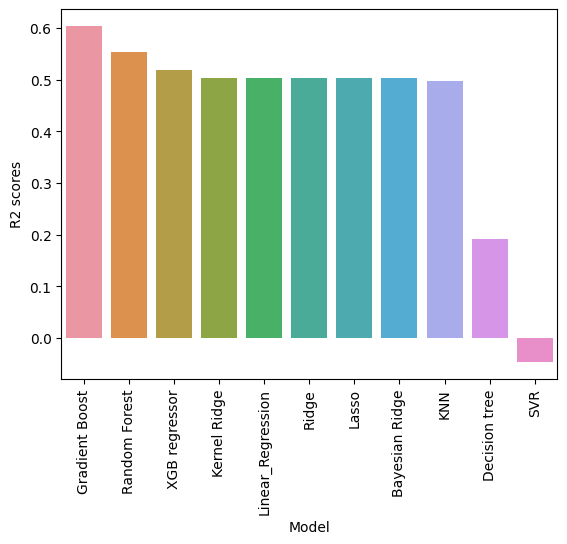

In [60]:
fig = plt.figure()
sns.barplot(x="Model", y='R2',data=model_performance)
plt.xlabel('Model')
plt.ylabel('R2 scores')
# plt.legend()
plt.xticks(rotation=90)
plt.show()
fig.clear()

#### The regression models don't seem to work well so far. Based on the above plot, ___Gradient Boost regressor___ works the best until now. 
#### But lets try polynomial regression rather than the linear one. This can done by obtaining __polynomial features__ (feature engineering) and then training the model on that transformed data.

In [23]:
model_dict = {'Linear_Regression': lr, 'Ridge': ridge, 'Bayesian Ridge': bayesianreg, 'KNN': knnreg, 
              'Kernel Ridge': kernelreg, 'Gradient Boost': gbreg}

In [159]:
poly_features = PolynomialFeatures(degree=3)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
model_list = list(model_dict.keys())
mae_scores = []
mse_scores = []
rmse_scores =[]
r2_scores = []

for key, model in model_dict.items():
    print(key)
    scores = []
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)
    
    # MAE
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)
#     print(f'Mean Absolute Error: {mae}')

    # MSE
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
#     print(f'Mean Squared Error: {mse}')

    # RMSE
    rmse = np.sqrt(mse)
    rmse_scores.append(rmse)
#     print(f'Root Mean Squared Error: {rmse}')

    # R² Score
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    
#     model_performance[key] = scores
#     print(f'R² Score: {r2}')
    

model_performance = {'Model': model_list, 'MAE': mae_scores, 'MSE': mse_scores, 'RMSE':rmse_scores, 'R2': r2_scores}

Linear_Regression
Ridge
Bayesian Ridge


C:\Users\akash\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.03892e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


KNN
Kernel Ridge


C:\Users\akash\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:243: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Gradient Boost


In [160]:
model_performance = pd.DataFrame(model_performance)
model_performance

,Model,MAE,MSE,RMSE,R2
0,Linear_Regression,811.425585,1.333705e+06,1154.861602,0.568425
1,Ridge,809.946775,1.332284e+06,1154.246034,0.568885
2,Bayesian Ridge,825.468594,1.337745e+06,1156.609078,0.567118
3,KNN,854.917112,1.511062e+06,1229.252694,0.511034
4,Kernel Ridge,871.949345,1.416582e+06,1190.202369,0.541607
5,Gradient Boost,809.559440,1.341318e+06,1158.152739,0.565962


### Okay, we got some improvement with polynomial features, but still quite poor. So based on degree 1 polynomial fit, lets select Ridge regression, Bayesian Ridge, and Gradient Boost regression. Tuning their model parameters using CV techinique might help with the performance. 

### ___Gradient Boost___

In [81]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [2, 10, 20], 'learning_rate': [0.1, 0.5, 1]}
grid_search = GridSearchCV(GradientBoostingRegressor(verbose=1), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(f"Best parameters: ", grid_search.best_params_)
print(f"Best parameters: ", {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100})

Best parameters:  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}


In [61]:
# Use the best model for training
# best_model = grid_search.best_estimator_
model = GradientBoostingRegressor(n_estimators=300, max_depth=2, learning_rate=0.1, verbose=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('r2: ', r2)
mae = mean_absolute_error(y_test, y_pred)
print('MAE: ', mae)

      Iter       Train Loss   Remaining Time 
         1     2629896.2316            3.21s
         2     2435877.0124            3.26s
         3     2276403.9381            3.29s
         4     2139991.9451            2.95s
         5     2023192.8535            3.29s
         6     1922954.3296            3.26s
         7     1834176.6852            3.82s
         8     1756766.1851            3.67s
         9     1686038.9721            4.06s
        10     1624288.6104            4.10s
        20     1278882.4520            4.71s
        30     1167720.4828            4.47s
        40     1126461.0265            4.44s
        50     1108115.4354            4.32s
        60     1099195.3797            4.07s
        70     1092681.1425            3.96s
        80     1087681.3838            3.78s
        90     1083667.7819            3.54s
       100     1079899.9062            3.44s
       200     1048596.4282            1.84s
       300     1019212.6228            0.00s
r2:  0.57

In [62]:
r2 = r2_score(y_test, y_pred)
print('r2: ', r2)
mae = mean_absolute_error(y_test, y_pred)
print('MAE: ', mae)

r2:  0.5710663631284074
MAE:  811.357151050388


### ___Visualizing the deviance of test and training set with the number of gradient boost iterations___

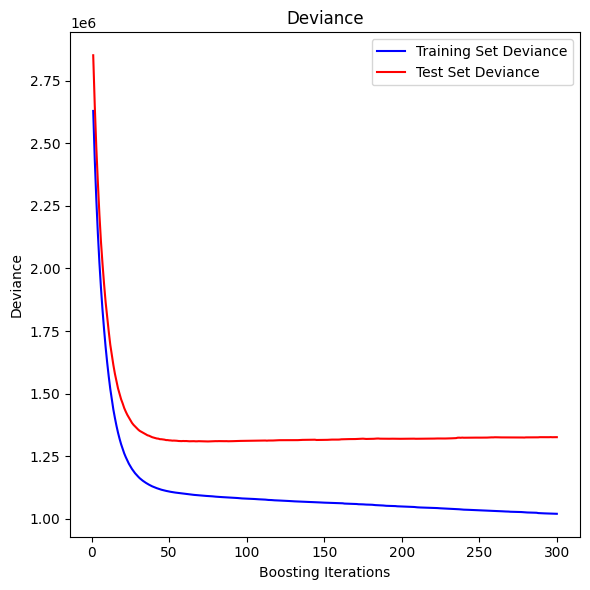

In [63]:
test_score = np.zeros(300, dtype=np.float64)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(300) + 1,
    model.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(300) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

### ___Random  forest___

In [109]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 200, 250], 'max_depth': [2, 10, 15]}
grid_search = GridSearchCV(RandomForestRegressor(verbose=1), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(f"Best parameters: ", grid_search.best_params_)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Do

[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   10.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   11.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   11.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.3s


Best parameters:  {'max_depth': 10, 'n_estimators': 100}


In [64]:
model = RandomForestRegressor(n_estimators=200, max_depth=10, verbose=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   10.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [65]:
r2 = r2_score(y_test, y_pred)
print('r2: ', r2)
mae = mean_absolute_error(y_test, y_pred)
print('MAE: ', mae)

r2:  0.5622833454082072
MAE:  814.711925311648


### ___XGB Regressor___

In [70]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [100, 200, 250], 'max_depth': [6, 10, 15], 'learning_rate':[0.1, 0.3, 0.5]}
grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(f"Best parameters: ", grid_search.best_params_)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


In [72]:
model = XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [73]:
r2 = r2_score(y_test, y_pred)
print('r2: ', r2)
mae = mean_absolute_error(y_test, y_pred)
print('MAE: ', mae)

r2:  0.5134659625343805
MAE:  860.7382213074123


### ___Bayesian Ridge___

In [93]:
param_grid = {'alpha_1':[1e-6, 1e-1, 10], 'alpha_2':[1e-6, 5e-6, 1e-3], 'lambda_1':[1e-6, 5e-6, 1e-3], 'lambda_2':[1e-6, 1e-1, 10]}
grid_search = GridSearchCV(BayesianRidge(verbose=True), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(f"Best parameters: ", grid_search.best_params_)

Convergence after  18  iterations
Convergence after  17  iterations
Convergence after  17  iterations
Convergence after  18  iterations
Convergence after  18  iterations
Convergence after  18  iterations
Convergence after  17  iterations
Convergence after  17  iterations
Convergence after  18  iterations
Convergence after  18  iterations
Convergence after  18  iterations
Convergence after  17  iterations
Convergence after  17  iterations
Convergence after  18  iterations
Convergence after  18  iterations
Convergence after  18  iterations
Convergence after  17  iterations
Convergence after  17  iterations
Convergence after  18  iterations
Convergence after  18  iterations
Convergence after  18  iterations
Convergence after  17  iterations
Convergence after  17  iterations
Convergence after  18  iterations
Convergence after  18  iterations
Convergence after  18  iterations
Convergence after  17  iterations
Convergence after  17  iterations
Convergence after  18  iterations
Convergence af

Convergence after  18  iterations
Convergence after  18  iterations
Convergence after  18  iterations
Convergence after  17  iterations
Convergence after  17  iterations
Convergence after  18  iterations
Convergence after  18  iterations
Convergence after  18  iterations
Convergence after  17  iterations
Convergence after  17  iterations
Convergence after  18  iterations
Convergence after  18  iterations
Convergence after  18  iterations
Convergence after  17  iterations
Convergence after  17  iterations
Convergence after  18  iterations
Convergence after  18  iterations
Convergence after  18  iterations
Convergence after  17  iterations
Convergence after  17  iterations
Convergence after  18  iterations
Convergence after  18  iterations
Convergence after  18  iterations
Convergence after  17  iterations
Convergence after  17  iterations
Convergence after  18  iterations
Convergence after  18  iterations
Convergence after  18  iterations
Convergence after  17  iterations
Convergence af

In [89]:
model = BayesianRidge(alpha_1=10, lambda_2=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [90]:
r2 = r2_score(y_test, y_pred)
print('r2: ', r2)
mae = mean_absolute_error(y_test, y_pred)
print('MAE: ', mae)

r2:  0.493365093384005
MAE:  933.1866970358476


In [92]:
model = BayesianRidge(alpha_1=0.1, lambda_2=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('r2: ', r2)
mae = mean_absolute_error(y_test, y_pred)
print('MAE: ', mae)

r2:  0.4933661143581092
MAE:  933.1844781604588
